In [110]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

# train utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# preprocessing
from sklearn.preprocessing import StandardScaler

In [2]:
%load_ext blackcellmagic

%%black

## Lab 1

- Значит задание по 0 лабе: рассчитать индекс удовлетворенности жизнью для [соответствующего датасета из книжки](https://github.com/ageron/handson-ml/tree/master/datasets/lifesat), на основании известных данных ВВП на душу (оттуда же) для не менее 20 точек, не считая известных.

- Рассчитывать будете двумя способами:

  - методом ближайших соседей
  - простой линейной регрессией (одномерной) с двумя коэффициентами


- Сделать свои функции для ближайших соседей и регрессии
  - для регрессии обязательно провести минимизацию методом наименьших квадратов! (и использовать готовые функции scikit-learn)
  - Результаты для ваших и библиотечных методов должны совпадать.
  - В методе ближайших соседей посчитать для числа соседей 1 и 3.
- Сравнить и сделать выводы. Реализация на языке Python. Не забудьте установить библиотеку scikit-learn.

## Вспомогательные функции

In [11]:
def prepare_country_stats(oecd_bli, gdp_per_capita):
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"] == "TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp_per_capita.set_index("Country", inplace=True)
    full_country_stats = pd.merge(
        left=oecd_bli, 
        right=gdp_per_capita, 
        left_index=True, 
        right_index=True
    )
    
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    keep_indices = list(set(range(36)) - set(remove_indices))
    return full_country_stats.iloc[keep_indices]#[["GDP per capita", "Life satisfaction"]]#


#### Удовлетворенность жизнью и ВВП на душу населения

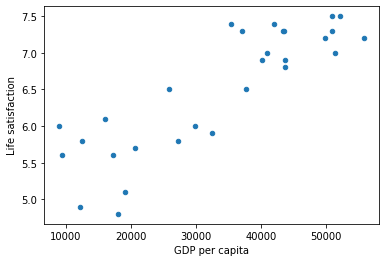

In [411]:
# Load the data
oecd_bli = pd.read_csv("./datasets/oecd_bli_2015.csv", thousands=",")
gdp_per_capita = pd.read_csv(
    "./datasets/gdp_per_capita.csv",
    thousands=",",
    delimiter="\t",
    encoding="latin1",
    na_values="n/a",
)


# Prepare the data
sample_data = prepare_country_stats(oecd_bli, gdp_per_capita)
X = np.c_[sample_data["GDP per capita"]]
y = np.c_[sample_data["Life satisfaction"]]

# Visualize the data
sample_data.plot(kind="scatter", x="GDP per capita", y="Life satisfaction")
plt.show()

In [120]:
X.shape, y.shape

((29, 1), (29, 1))

## Встроенные модели

### Linear regression model

In [413]:
model = LinearRegression()
scores = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring=make_scorer(mean_squared_error))
scores = scores.mean()
print(f"Linear regression Mean Error = {scores}")

def k_fold_validation(model_class, X, y, cv=5, model_params=None):
	if model_params == None:
		model_params = {}
	
	k_fold = KFold(n_splits=cv)
	k_fold.get_n_splits(X)

	scores = []
	for train_index, test_index in k_fold.split(X):
		model = model_class(**model_params)
		X_train, X_test = X[train_index], X[test_index]
		y_train, y_test = y[train_index], y[test_index]
		# normalize data
		scaler = StandardScaler()
		scaler.fit(X_train)
		X_train = scaler.transform(X_train)
		X_test = scaler.transform(X_test)
		
		model.fit(X_train, y_train)
		pred = model.predict(X_test)
		result = mean_squared_error(y_test, pred)
		scores.append(result)

	scores = np.array(scores).mean()

	return scores

scores = k_fold_validation(LinearRegression, X, y, cv=5, model_params=None)
print(f"Linear regression Mean Error = {scores}")

Linear regression Mean Error = 0.2766686042360626
Linear regression Mean Error = 0.27666860423606277


In [ ]:
"""
model.coef_
[[0.61967346]]
[[0.67627008]]
[[0.70577578]]
[[0.76452688]]
[[0.39163706]]
"""

### KNN model

In [123]:
for k_neighbors in [1, 3, 5, 7, 10]:
    scores = k_fold_validation(
        model_class=KNeighborsRegressor,
        X=X,
        y=y,
        cv=5,
        model_params={"n_neighbors": k_neighbors},
    )
    print(f"KNN Mean Error with k_neighbors={k_neighbors} equals {scores}")

KNN Mean Error with k_neighbors=1 equals 0.35520000000000007
KNN Mean Error with k_neighbors=3 equals 0.2937925925925929
KNN Mean Error with k_neighbors=5 equals 0.17607999999999993
KNN Mean Error with k_neighbors=7 equals 0.1866897959183674
KNN Mean Error with k_neighbors=10 equals 0.2829633333333331


## Модели с нуля

### Linear regression model

In [396]:
class MyLinearRegression:
    def __init__(self, learning_rate=0.1, iterations=10):
        self.learning_rate = learning_rate
        self.iterations = iterations

    def fit(self, X, y):

        # no_of_training_examples, no_of_features
        self.m = X.shape[0]
        self.n = X.shape[1]

        # weight initialization
        self.W = np.ones((self.n, 1))
        self.b = 1
        self.X = np.array(X)
        self.y = np.array(y)

        # gradient descent learning
        for _ in range(self.iterations):
            # self.update_weights()
            self.update_weights_v2()
        print(self.W)

    def update_weights(self):

        # calculate gradients
        Y_pred = self.predict(self.X) / self.m
        Y_pred = Y_pred.reshape(self.Y.shape)
        # print(Y_pred.shape)
        dW = -2 * self.X.T @ (self.Y - Y_pred) / self.m
        db = -2 * (self.Y - Y_pred).sum() / self.m
        # print(self.W, db)
        # print(dW, self.X.T.shape, self.Y.shape, (self.X.T.dot(self.Y - Y_pred)).shape)
        # print(db)
        self.W -= self.learning_rate * dW
        self.b -= self.learning_rate * db

    def update_weights_v2(self):
        batch_size = 2
        for batch in range(len(self.X) // batch_size):
            start = batch * batch_size
            stop = (batch * batch_size) + batch_size

            X_batch = self.X[start:stop]
            y_batch = self.y[start:stop]

            Y_pred = self.predict(X_batch)
            dW = -2 * X_batch.T @ (y_batch - Y_pred) / self.m
            db = -2 * self.b*(y_batch - Y_pred).sum() / self.m
    
            self.W -= self.learning_rate * dW
            self.b -= self.learning_rate * db

    def predict(self, X):
        return X @ self.W + self.b


model = MyLinearRegression(iterations=1, learning_rate=0.0001)
model.fit(X, y)
model.W

[[nan]]


C:\Users\dimweb\AppData\Local\Temp\ipykernel_15272\3648896529.py:49: RuntimeWarning: overflow encountered in double_scalars
  db = -2 * self.b*(y_batch - Y_pred).sum() / self.m
C:\Users\dimweb\AppData\Local\Temp\ipykernel_15272\3648896529.py:55: RuntimeWarning: invalid value encountered in add
  return X @ self.W + self.b


array([[nan]])

In [408]:
scores = k_fold_validation(
    model_class=MyLinearRegression,
    X=X,
    y=y,
    cv=5,
    model_params={
        "learning_rate": 0.01, 
        "iterations": 55
    }
)

print(scores)

[[0.72743273]]
[[0.75930128]]
[[0.77709863]]
[[0.8259135]]
[[0.58205059]]
1.1748654567186834


In [ ]:
cur_x = 3  # The algorithm starts at x=3
rate = 0.01  # Learning rate
precision = 0.000001  # This tells us when to stop the algorithm
previous_step_size = 1  #
max_iters = 10000  # maximum number of iterations
iters = 0  # iteration counter
df = lambda x: 2 * (x + 5)  # Gradient of our function

while previous_step_size > precision and iters < max_iters:
    prev_x = cur_x  # Store current x value in prev_x
    cur_x = cur_x - rate * df(prev_x)  # Grad descent
    previous_step_size = abs(cur_x - prev_x)  # Change in x
    iters = iters + 1  # iteration count
    print("Iteration", iters, "\nX value is", cur_x)  # Print iterations

print("The local minimum occurs at", cur_x)

In [58]:
W = np.ones(X.shape[1])
b = 0

reg = lambda x: x @ W + b
cost_func = lambda x: (y - reg(x)) ** 2
dW_cost_func = lambda x: 2*x.T@(y - reg(x))
db_cost_func = lambda x: 2*(y - reg(x))
lr = 0.01
steps = 5
for i in range(steps):
	W -= lr * dW_cost_func(X)
	b -= lr * db_cost_func(X)

W, b

(array([2.87081828e+44]),
 array([5.19900253e+46, 5.41859602e+46, 7.02770229e+46, 7.17436666e+46,
        9.18187362e+46, 9.92618895e+46, 1.03718576e+47, 1.09789232e+47,
        1.19038377e+47, 1.48505828e+47, 1.56144937e+47, 1.71483054e+47,
        1.86520193e+47, 2.02928590e+47, 2.12698301e+47, 2.16316192e+47,
        2.30277705e+47, 2.35387067e+47, 2.40999384e+47, 2.48796372e+47,
        2.50353239e+47, 2.51047495e+47, 2.51315383e+47, 2.86313976e+47,
        2.91988533e+47, 2.92604507e+47, 2.94837309e+47, 2.99220595e+47,
        3.20413200e+47]))

In [170]:
import numpy as np

X_0 = np.random.rand(29,1)
m = np.random.randint(low = 1, high = 20,size = (1,1))  #parametri random tra low e high
q = np.random.rand(1)
y_0 = (X_0 @ m) + q 

noise = np.random.randn(y.shape[0], y.shape[1])
y = y + noise

X_0.shape, y_0.shape



((29, 1), (29, 1))

In [263]:
scores = k_fold_validation(
    model_class=MyLinearRegression,
    X=X,
    y=y,
    cv=5,
    model_params={
        "learning_rate": 0.01, 
        "iterations": 16
    }
)
scores

1.7151663672154736

In [74]:
def partial_derivative(X_batch, y_batch, m_stat):

  y_pred = X_batch @ m_stat
  n = len(X_batch)

  df_dm =  (-2/n) * (X_batch.T @ (y_batch - y_pred))
  df_dm = df_dm.reshape(len(df_dm),-1)

  return df_dm

In [92]:
def custom_mean_squared_error(X,y,m_stat):
  y_pred = X @ m_stat
  mse = np.sum(((y_pred - y)**2),axis = 0) / len(X)
  
  return mse

In [93]:
def training(X, y, batch_size, lr, epochs):
  
  for epoch in range(epochs):

    #random initial statistics
    if epoch == 0:
      m_stat = np.random.rand(X.shape[1],1)

    #shuffle X and y using same permutation
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    X = X[indices]
    y = y[indices]

    #store comulative derivative
    cumulative_derivative = np.zeros((X.shape[1],1))

    for batch in range(len(X)//batch_size):
      start = batch*batch_size
      stop = (batch*batch_size) + batch_size

      X_batch = X[start:stop]
      y_batch = y[start:stop]
      
      #derivative
      cumulative_derivative = cumulative_derivative + partial_derivative(X_batch, y_batch, m_stat)

      #updating rule
      m_stat = m_stat - (lr*cumulative_derivative)
    
    print(f"epoch: {epoch} ----> MSE: {custom_mean_squared_error(X,y,m_stat)}")
      
  return m_stat

In [109]:
batch_size = 10
lr = 0.01
epochs = 4

m_stat = training(X, y, batch_size, lr, epochs)

epoch: 0 ----> MSE: [2.19965704e+38]
epoch: 1 ----> MSE: [8.79607695e+67]
epoch: 2 ----> MSE: [2.74976568e+97]
epoch: 3 ----> MSE: [1.39853423e+127]


In [106]:
batch_size = 4
lr = 0.1
epochs = 10

m_stat = training(X_0,y_0, batch_size,lr,epochs)

epoch: 0 ----> MSE: [38.44501756]
epoch: 1 ----> MSE: [8.11515413]
epoch: 2 ----> MSE: [3.41248788]
epoch: 3 ----> MSE: [1.79261385]
epoch: 4 ----> MSE: [0.77074466]
epoch: 5 ----> MSE: [0.15865555]
epoch: 6 ----> MSE: [0.13618797]
epoch: 7 ----> MSE: [0.11733463]
epoch: 8 ----> MSE: [0.11290029]
epoch: 9 ----> MSE: [0.1120361]
